In [ ]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import keras,os
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
import numpy as np
from keras.models import Model
from keras import optimizers , layers, applications
filenames = os.listdir('/content/drive/MyDrive/ASD/AutismDataset')
print(filenames)

['test', 'consolidated', 'valid', 'train']


In [ ]:
filenames = os.listdir('/content/drive/MyDrive/ASD/AutismDataset/train')
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'Autistic':
        categories.append(str(1))
    else:
        categories.append(str(0))

# train_df is a DataFrame with two columns: 'filename' and 'category', and it contains data from the filenames and categories lists. Each row corresponds to a pair of filename and category.
train_df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

**Size of train**

In [ ]:
train_filenames = os.listdir('/content/drive/MyDrive/ASD/AutismDataset/train')

print(len(train_filenames))  #should be 2540

2550


<Axes: >

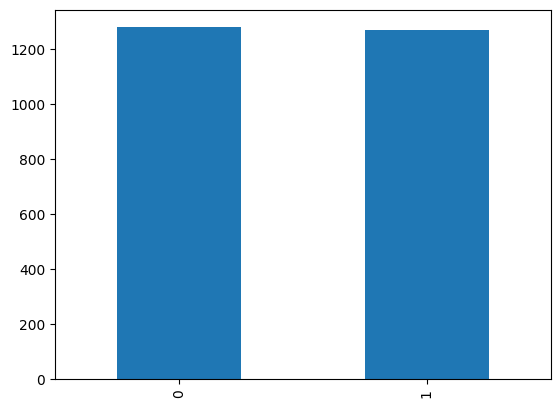

In [ ]:
train_df['category'].value_counts().plot.bar()

In [ ]:
test_filenames = os.listdir('/content/drive/MyDrive/ASD/AutismDataset/test')
print(len(test_filenames))  #should be 300

300


In [ ]:
test_filenames = os.listdir('/content/drive/MyDrive/ASD/AutismDataset/test')
categories = []
for filename in test_filenames:
    category = filename.split('.')[0] #if filename is something like "cat.123.jpg", the result of filename.split('.')[0] would be "cat," which is often used as a category label in image datasets to indicate the class or category to which the image belongs.
    if category == 'Autistic':
        categories.append(str(1))
    else:
        categories.append(str(0))

test_df = pd.DataFrame({
    'filename': test_filenames,
    'category': categories
})

<Axes: >

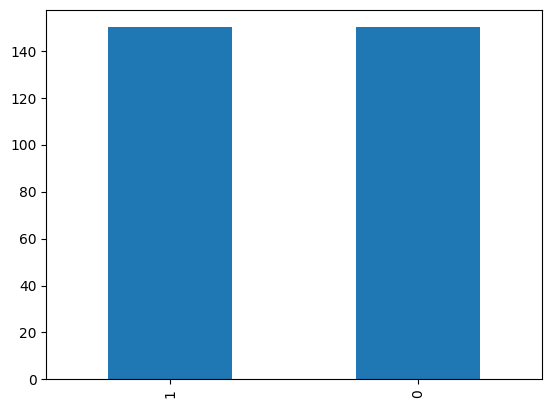

In [ ]:
test_df['category'].value_counts().plot.bar()

In [ ]:
test_df.head()

,filename,category
0,Autistic.100.jpg,1
1,Autistic.104.jpg,1
2,Autistic.105.jpg,1
3,Autistic.101.jpg,1
4,Autistic.1.jpg,1


In [ ]:
train_df.head()

,filename,category
0,Non_Autistic.126.jpg,0
1,Non_Autistic.1244.jpg,0
2,Non_Autistic.1264.jpg,0
3,Non_Autistic.1250.jpg,0
4,Non_Autistic.1237.jpg,0


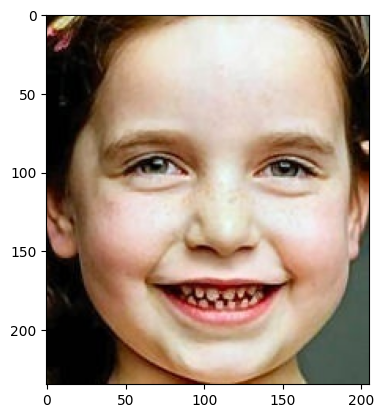

In [ ]:
sample = random.choice(train_filenames)
image = load_img('/content/drive/MyDrive/ASD/AutismDataset/train/'+sample)
plt.imshow(image)

In [ ]:
from keras.applications import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model
from keras import optimizers

image_size = 224
input_shape = (image_size, image_size, 3)

# Hyperparameters
epochs = 32
batch_size = 20

# Load MobileNet model
pre_trained_model = MobileNet(input_shape=input_shape, include_top=False, weights="imagenet")

# Choose a layer from MobileNet
last_layer = pre_trained_model.get_layer('conv_pw_13_relu')

last_output = last_layer.output

# Flatten the output layer to 1 dimension
x = GlobalAveragePooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-3, momentum=0.9),
              metrics=['accuracy'])

model.summary()


17225924/17225924 [==============================] - 0s 0us/step


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

The train_test_split function is used to split the original train_df DataFrame into two parts: train_df and validate_df. The split is done for model training and validation, with 90% of the data going to training (train_df) and 10% to validation (validate_df).

In [ ]:
# Prepare Test and Train Data
train_df, validate_df = train_test_split(train_df, test_size=0.1)  # 0.1 ensures the 90:10 ratio for train and validation(i.e. nothing but test)

# Check if 'level_0' column exists and drop it. This is done to clean up the DataFrames and remove unnecessary columns.
if 'level_0' in train_df.columns:
    train_df = train_df.drop(['level_0'], axis=1)
if 'level_0' in validate_df.columns:
    validate_df = validate_df.drop(['level_0'], axis=1)

# Reset the index
# The reset_index method is used with the parameter drop=True. This operation resets the index of the DataFrame and drops the existing index,
# replacing it with the default integer index. The drop=True ensures that the old index is not added as a new column in the DataFrame.
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

# Other code remains the same
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
print(total_train)
print(total_validate)


2295
255


**Training and Validation Generator**

These generators are then used during the training process of a neural network, providing a continuous stream of augmented and preprocessed images to the model. This helps improve the model's generalization and performance on unseen data.

In [ ]:
# Training Generator
# ImageDataGenerator is a class mainly used for image augmentation which is used to apply various transforamtions to the input images, such as rotation, rescaling, shearing, zooming, horizontal flipping, and shifting to create new variations of the original images.
# so in following code we are creating data generator and then in next code we are applying it to train_df dataframe i.e train dataset images
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

# flow_from_dataframe is used to generate a flow of augmented image data from the training DataFrame (train_df).
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    '/content/drive/MyDrive/ASD/AutismDataset/train/',
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 2295 validated image filenames belonging to 2 classes.


In [ ]:
# Validation Generator
# ImageDataGenerator is used for validation without augmentation. Only rescaling is applied for normalization.
validation_datagen = ImageDataGenerator(rescale=1./255)

#Similar to the training generator, flow_from_dataframe is used for generating batches of validation data.
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    '/content/drive/MyDrive/ASD/AutismDataset/train/',
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 255 validated image filenames belonging to 2 classes.


**The overall purpose of following code**

 is to train the MobileNet model on the augmented training data, and at the end of each epoch, validate its performance on the validation data. The training history is stored in the history variable, which can be used for analyzing and visualizing the model's performance over epochs.

In [ ]:
#Fit Model (MobileNet)
# model.fit is used to train the model.
history = model.fit(
    train_generator, # provides batches of augmented training images and labels during training.
    epochs=epochs,
    validation_data=validation_generator, # is used for validation during training.
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size)

Epoch 1/32
114/114 [==============================] - 91s 424ms/step - loss: 0.6082 - accuracy: 0.7042 - val_loss: 0.4701 - val_accuracy: 0.8042
Epoch 2/32
114/114 [==============================] - 42s 370ms/step - loss: 0.4511 - accuracy: 0.7851 - val_loss: 1.0299 - val_accuracy: 0.7083
Epoch 3/32
114/114 [==============================] - 40s 355ms/step - loss: 0.3931 - accuracy: 0.8193 - val_loss: 0.7019 - val_accuracy: 0.7542
Epoch 4/32
114/114 [==============================] - 43s 377ms/step - loss: 0.3709 - accuracy: 0.8347 - val_loss: 0.3283 - val_accuracy: 0.8500
Epoch 5/32
114/114 [==============================] - 41s 358ms/step - loss: 0.3361 - accuracy: 0.8567 - val_loss: 1.1760 - val_accuracy: 0.6500
Epoch 6/32
114/114 [==============================] - 41s 359ms/step - loss: 0.3255 - accuracy: 0.8624 - val_loss: 0.9530 - val_accuracy: 0.6458
Epoch 7/32
114/114 [==============================] - 42s 364ms/step - loss: 0.2976 - accuracy: 0.8681 - val_loss: 0.3057 - val_ac

In [ ]:
history_df = pd.DataFrame(history.history)
history_df

,loss,accuracy,val_loss,val_accuracy
0,0.608248,0.704176,0.470060,0.804167
1,0.451067,0.785055,1.029865,0.708333
2,0.393110,0.819341,0.701922,0.754167
3,0.370930,0.834725,0.328303,0.850000
4,0.336131,0.856703,1.175969,0.650000
5,0.325477,0.862418,0.953004,0.645833
6,0.297646,0.868132,0.305671,0.887500
7,0.282040,0.875165,0.297543,0.883333
8,0.250603,0.900659,0.409674,0.833333
9,0.244181,0.899780,0.494049,0.845833


In summary, this code snippet is assessing how well the trained model generalizes to new, unseen data (validation dataset) and prints the obtained accuracy and loss metrics.

In [ ]:
# Evaluate the model on the validation dataset
loss, accuracy = model.evaluate(validation_generator, steps=total_validate//batch_size, workers=12)

# Print the evaluation results
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))


12/12 [==============================] - 1s 49ms/step - loss: 0.3863 - accuracy: 0.8958
Test: accuracy = 0.895833  ;  loss = 0.386294 


**To display the training and validation accuracy curves**, you can use the history object returned by the fit function. The history object contains information about the training process, including accuracy and loss values for each epoch. This visualization helps you assess the training process and identify potential issues like overfitting or underfitting.

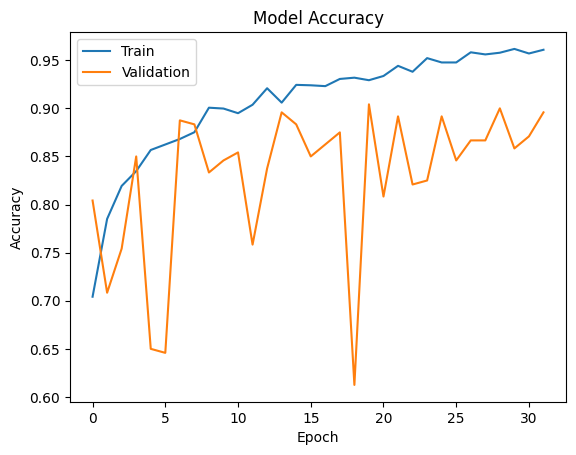

In [ ]:
# Assuming 'history' is the object returned by model.fit

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# # Show seaborn lineplot
# sns.lineplot(data=history_df.loc[:, ["acc", "val_acc"]], palette=['b', 'r'], dashes=False)
# sns.set_style("whitegrid")

plt.show()



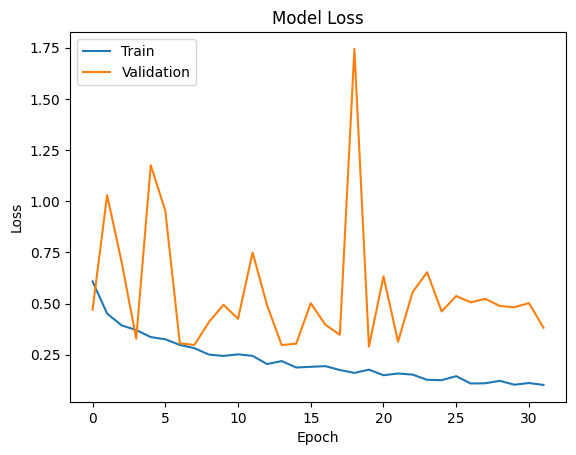

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


This code creates a countplot showing the distribution of predicted labels in each class. The x-axis represents the category, and the y-axis represents the count. This type of visualization provides insights into how well your model is performing on each class and also useful in Class Imbalance Detection.

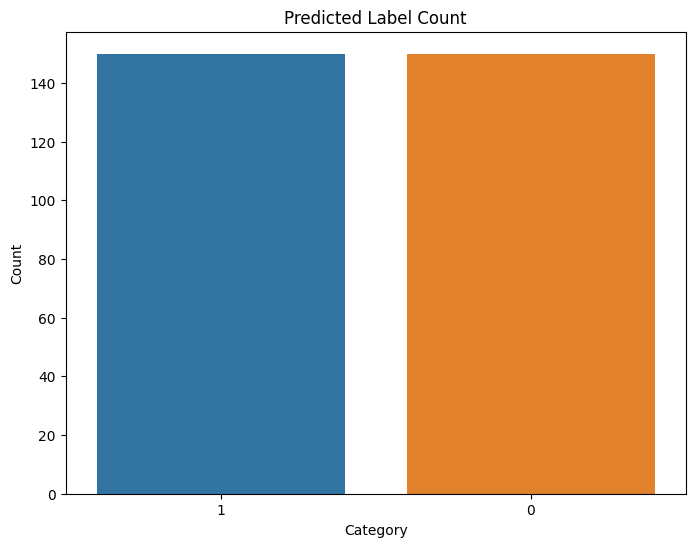

In [ ]:

# Assuming 'test_df' contains the predicted labels

# Plot predicted label count
plt.figure(figsize=(8, 6))
sns.countplot(x='category', data=test_df)
plt.title('Predicted Label Count')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()


In [ ]:
#Prepare Testing
test_filenames = os.listdir('/content/drive/MyDrive/ASD/AutismDataset/test/')
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [ ]:
#Create Testing Generator
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df,
    '/content/drive/MyDrive/ASD/AutismDataset/test/',
    x_col='filename',
    y_col=None,
    class_mode=None,
    batch_size=batch_size,
    target_size=(image_size, image_size),
    shuffle=False
)

Found 300 validated image filenames.


The purpose of this code is to predict the categories for the test images and assign binary labels based on a specified threshold for further analysis or evaluation.

In [ ]:
# Predict
threshold = 0.5
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))
threshold = 0.5
test_df['category'] = np.where(predict > threshold, 1,0)


15/15 [==============================] - 4s 225ms/step


In [ ]:
# See Predicted Result
sample_test = test_df.sample(n=9).reset_index()
print(sample_test.head())  # Print the first few rows to inspect the columns

   index             filename  category
0     62      Autistic.28.jpg         1
1    256  Non_Autistic.74.jpg         1
2    260  Non_Autistic.66.jpg         0
3     50     Autistic.143.jpg         1
4     38     Autistic.137.jpg         1


In [ ]:
test_imgs = ["/content/drive/MyDrive/ASD/AutismDataset/test/{}".format(i) for i in test_filenames]


In [ ]:
import cv2

# Set the dimensions for images
nrows = 150
ncolumns  = 150
channels = 3

# Read and process the images: Function returns X,y. X - list of resized images, y - list of labels for the images

def read_and_process_image(list_of_images):
    X = []
    y = []

    for image in list_of_images:
        X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrows, ncolumns), interpolation = cv2.INTER_CUBIC))
        if 'Non_Autistic' in image:
            y.append(0)
        else:
            y.append(1)

    return X,y

In [ ]:
# Read and resize test images
random.shuffle(test_imgs)
X_test, y_test = read_and_process_image(test_imgs)
X = np.array(X_test)
#test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Replace 'true_labels' with the actual true labels for your test set
true_labels =  test_df['category'].values

# Set the threshold for binary classification
threshold = 0.5

# Apply the threshold to convert probabilities to binary predictions
predicted_labels = np.where(predict > threshold, 1, 0)

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Print a classification report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels))


Confusion Matrix:
[[134   0]
 [  0 166]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       134
           1       1.00      1.00      1.00       166

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



Text(0.5, 1.0, 'Confusion Matrix')

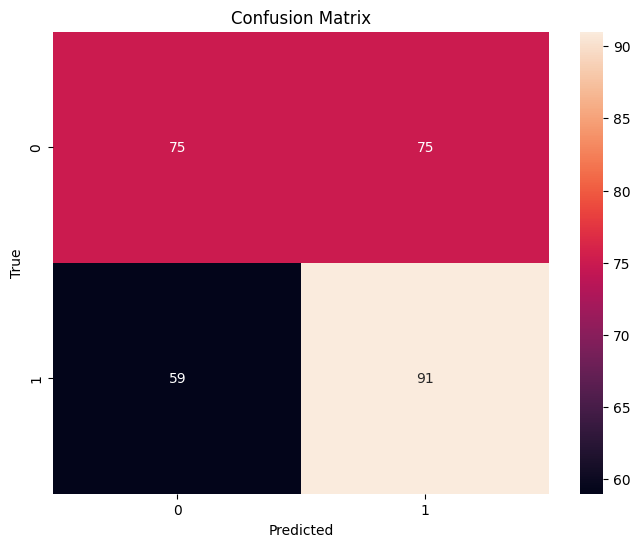

In [ ]:
# Generating Confusion Matrix for the predictions against true labels
cn_matrix= confusion_matrix(y_test, test_df['category'])
cn_matrix
# Plotting the True Positives, True Negatives, False Positives and False Negatives from model's predictions
f, ax = plt.subplots(figsize = (8,6))
ax = sns.heatmap(cn_matrix, annot=True)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")

The purpose of this code is to visually inspect a sample of test images and their corresponding predicted categories to assess the model's performance.

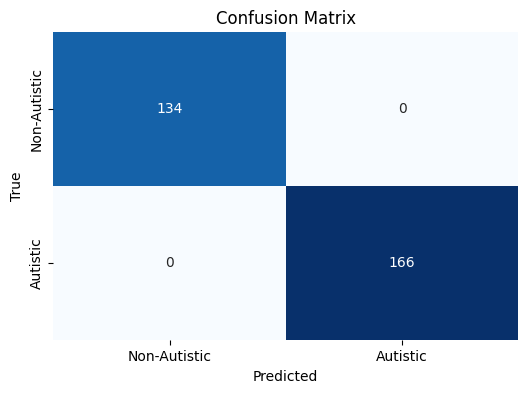

True Positives: 166
True Negatives: 134
False Positives: 0
False Negatives: 0


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have the true labels (true_labels) and predicted labels (predicted_labels) defined

# Calculate the confusion matrix
conf_mat = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Autistic', 'Autistic'],
            yticklabels=['Non-Autistic', 'Autistic'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Extract True Positives, True Negatives, False Positives, and False Negatives
tn, fp, fn, tp = conf_mat.ravel()

# Print the counts
print(f'True Positives: {tp}')
print(f'True Negatives: {tn}')
print(f'False Positives: {fp}')
print(f'False Negatives: {fn}')


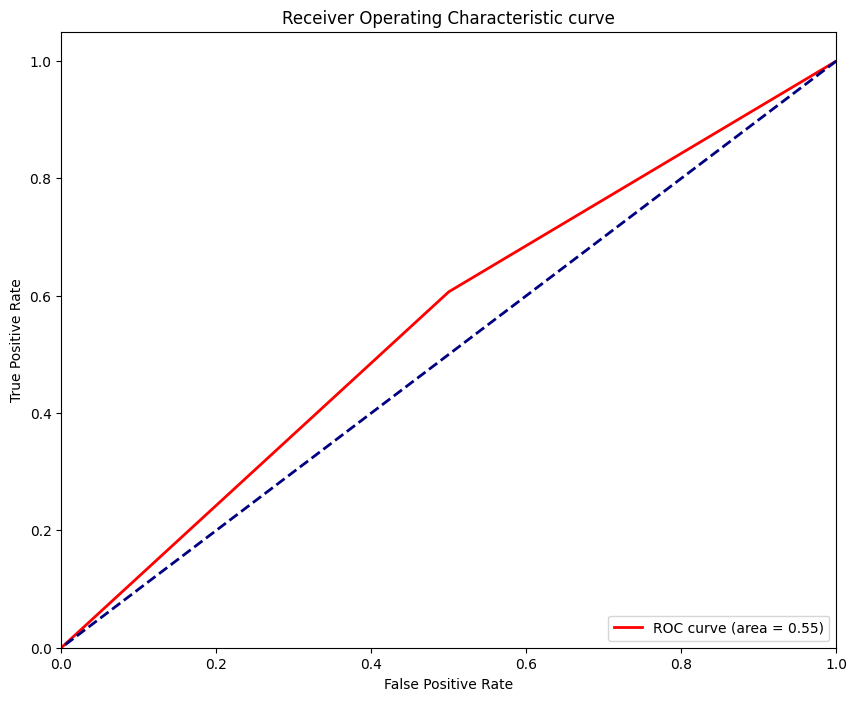

In [ ]:
# Let's plot the AUC-ROC curve to assess the performance of our model
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, test_df['category'])
roc_auc= auc(fpr, tpr)
plt.figure(figsize = (10,8))
plt.plot(fpr, tpr, color = 'red', lw = 2, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([1,0], [1,0], color = 'navy', lw = 2, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Receiver Operating Characteristic curve")
plt.legend(loc = 'lower right')

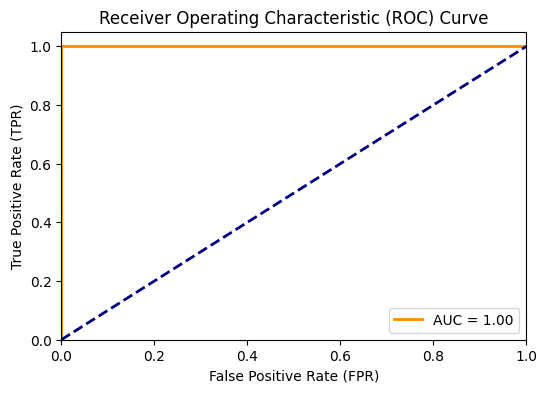

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you have true_labels and predicted_labels defined
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, predicted_labels)

# Calculate the Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# Save the MobileNet model in the native Keras format
model.save('mobilenet_model')

# Load the MobileNet model
loaded_model = keras.models.load_model('mobilenet_model')


REsult 


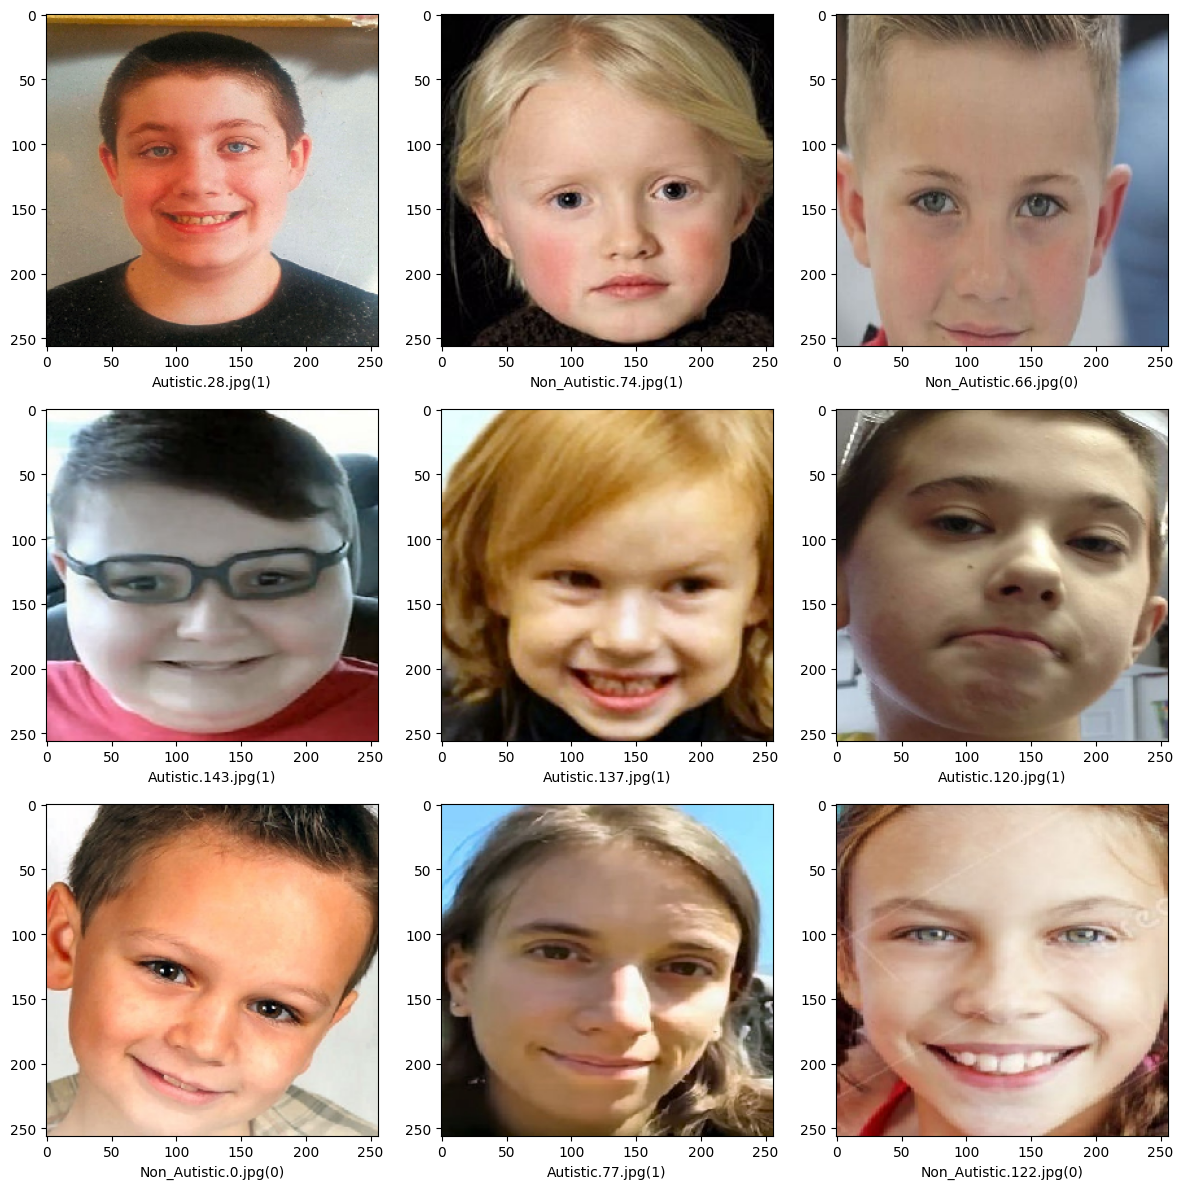

In [ ]:

print("REsult " )
plt.figure(figsize=(12, 12))
for index, row in sample_test.iterrows():
    filename = row['filename']
    # Ensure 'category' is present in the columns of sample_test
    if 'category' in sample_test.columns:
        category = row['category']
        img = load_img('/content/drive/MyDrive/ASD/AutismDataset/test/'+filename, target_size=(256, 256))
        plt.subplot(3, 3, index+1)
        plt.imshow(img)
        plt.xlabel(filename + '(' + "{}".format(category) + ')')
plt.tight_layout()
plt.show()


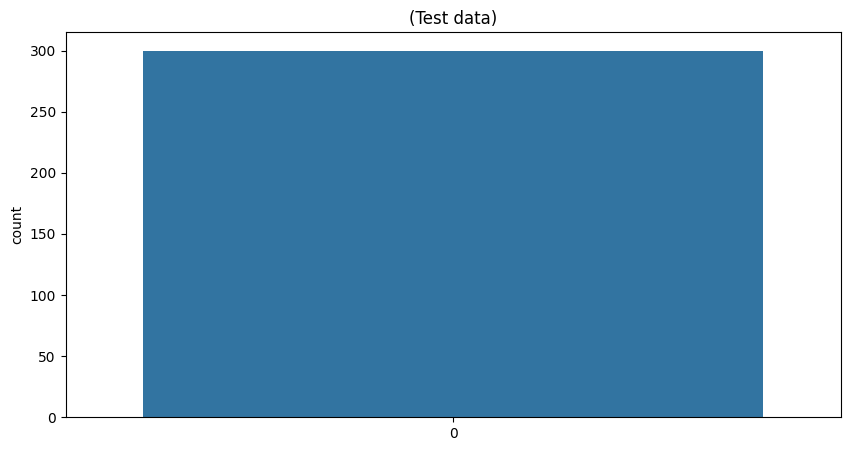

In [ ]:
import seaborn as sns  # Add this line to import Seaborn

submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission_13010030.csv', index=False)

plt.figure(figsize=(10, 5))
sns.countplot(submission_df['label'])
plt.title("(Test data)")
plt.show()  # Add this line to display the plot
